In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import PIL

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
import pathlib

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [4]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 7s 0us/step


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


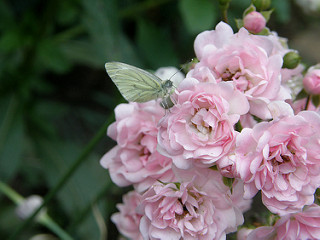

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

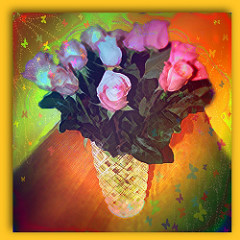

In [7]:
PIL.Image.open(str(roses[1]))

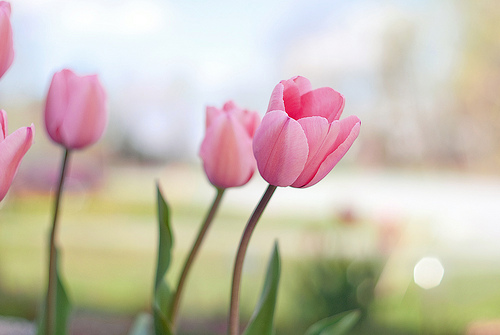

In [8]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
tf.keras.preprocessing.image_dataset_from_directory??

In [13]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

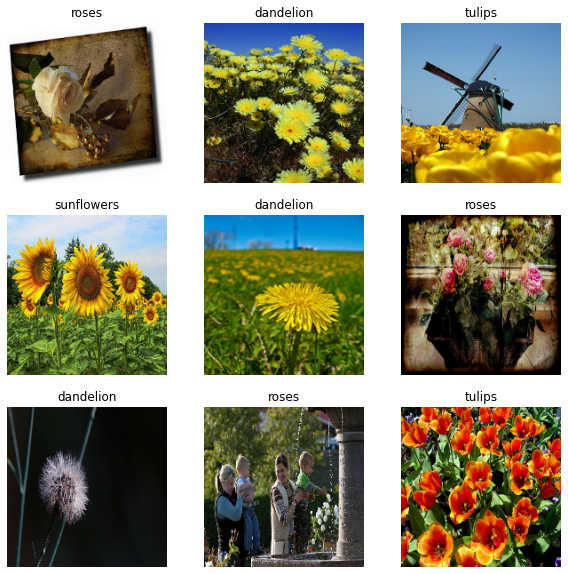

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [15]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1. / 255)

In [19]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [20]:
num_classes = 5

model = Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [23]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [28]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 3s 27ms/step - loss: 1.2912 - accuracy: 0.4390 - val_loss: 1.0522 - val_accuracy: 0.5736
Epoch 2/10
92/92 [==============================] - 1s 13ms/step - loss: 0.9507 - accuracy: 0.6322 - val_loss: 0.9224 - val_accuracy: 0.6308
Epoch 3/10
92/92 [==============================] - 1s 13ms/step - loss: 0.7263 - accuracy: 0.7292 - val_loss: 0.8852 - val_accuracy: 0.6417
Epoch 4/10
92/92 [==============================] - 1s 13ms/step - loss: 0.4935 - accuracy: 0.8300 - val_loss: 0.8607 - val_accuracy: 0.6744
Epoch 5/10
92/92 [==============================] - 1s 13ms/step - loss: 0.2957 - accuracy: 0.9050 - val_loss: 1.0063 - val_accuracy: 0.6744
Epoch 6/10
92/92 [==============================] - 1s 13ms/step - loss: 0.1542 - accuracy: 0.9523 - val_loss: 1.1895 - val_accuracy: 0.6458
Epoch 7/10
92/92 [==============================] - 1s 13ms/step - loss: 0.0720 - accuracy: 0.9816 - val_loss: 1.4699 - val_accuracy: 0.6689
Epoch 8/10
92

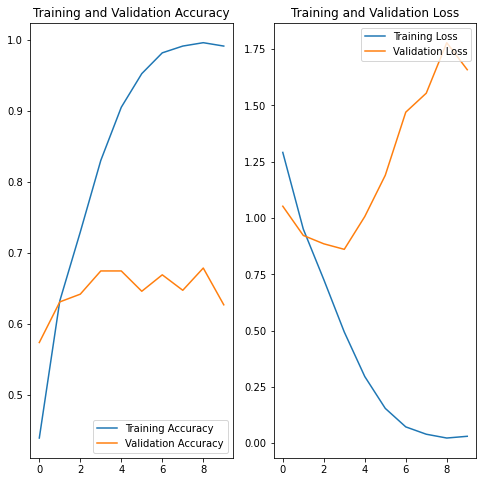

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 과적합 

위의 도표에서 훈련 정확도는 시간이 지남에 따라 선형 적으로 증가하는 반면 검증 정확도는 훈련 과정에서 약 60 % 지연됩니다. 또한 훈련 정확도와 검증 정확도 간의 정확도 차이가 눈에 띕니다. 이는 과적 합의 징후입니다.

훈련 예제가 적을 때 모델은 새로운 예제에서 모델의 성능에 부정적인 영향을 미칠 정도로 훈련 예제에서 노이즈 나 원치 않는 세부 정보를 학습합니다. 이 현상을 과적 합이라고합니다. 이는 모델이 새 데이터 세트에서 일반화하는 데 어려움이 있음을 의미합니다.

훈련 과정에서 과적 합과 싸우는 방법에는 여러 가지가 있습니다. 이 자습서에서는 데이터 증대를 사용하고 모델에 드롭 아웃 을 추가합니다.

In [30]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

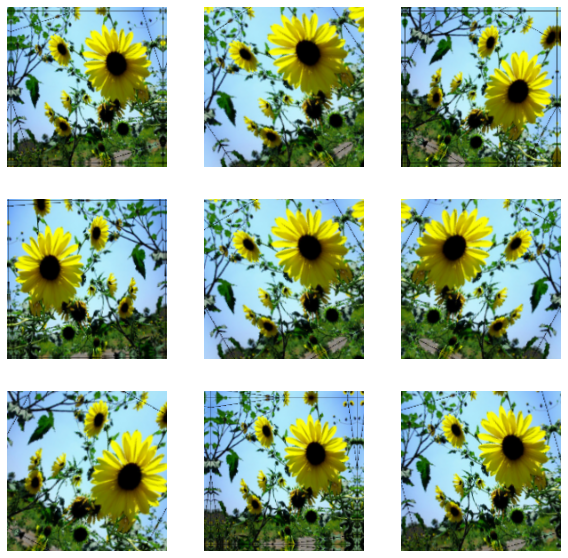

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [32]:
model = Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [33]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [35]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 2s 18ms/step - loss: 1.3719 - accuracy: 0.4091 - val_loss: 1.1069 - val_accuracy: 0.5627
Epoch 2/15
92/92 [==============================] - 2s 17ms/step - loss: 1.0585 - accuracy: 0.5719 - val_loss: 1.0143 - val_accuracy: 0.6049
Epoch 3/15
92/92 [==============================] - 2s 17ms/step - loss: 0.9798 - accuracy: 0.6172 - val_loss: 0.9310 - val_accuracy: 0.6417
Epoch 4/15
92/92 [==============================] - 2s 16ms/step - loss: 0.8935 - accuracy: 0.6553 - val_loss: 0.9870 - val_accuracy: 0.6199
Epoch 5/15
92/92 [==============================] - 2s 16ms/step - loss: 0.8586 - accuracy: 0.6788 - val_loss: 0.8478 - val_accuracy: 0.6689
Epoch 6/15
92/92 [==============================] - 2s 17ms/step - loss: 0.8046 - accuracy: 0.6829 - val_loss: 0.8410 - val_accuracy: 0.6757
Epoch 7/15
92/92 [==============================] - 2s 17ms/step - loss: 0.7701 - accuracy: 0.6975 - val_loss: 0.7840 - val_accuracy: 0.7016
Epoch 8/15
92

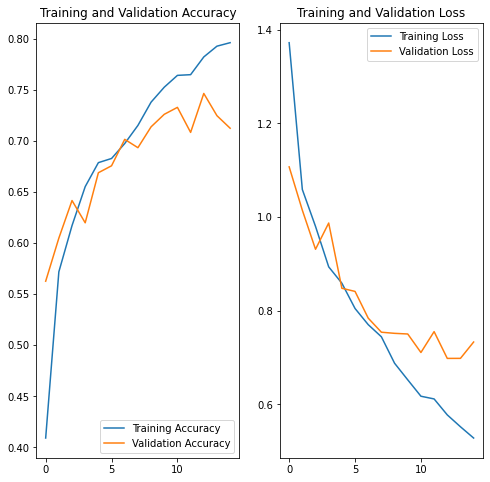

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 0us/step
This image most likely belongs to sunflowers with a 95.62 percent confidence.
